In [3]:
import numpy as np
import random
import types
import qiskit
import qtm.evolution
import qtm.random_circuit
import qtm.state
import qtm.qcompilation
import qtm.ansatz
import qtm.ecircuit
%load_ext autoreload
%autoreload 2


In [83]:
qtm.random_circuit.random_circuit2(3, 5, qtm.constant.clifford_set).draw()

┌───┐     ┌───┐┌───┐┌───┐     
q_0: ┤ H ├──■──┤ X ├┤ H ├┤ H ├─────
     ├───┤┌─┴─┐└─┬─┘├───┤├───┤┌───┐
q_1: ┤ S ├┤ X ├──┼──┤ H ├┤ S ├┤ S ├
     ├───┤├───┤  │  ├───┤├───┤└───┘
q_2: ┤ S ├┤ S ├──■──┤ H ├┤ H ├─────
     └───┘└───┘     └───┘└───┘     
c: 3/══════════════════════════════

In [92]:
# vdagger = qtm.state.create_haar_state_inverse(3)
vdagger = qtm.state.create_ghz_state_inverse(3)
pool = qtm.constant.clifford_set

def fitness(qc: qiskit.QuantumCircuit):
    compiler = qtm.qcompilation.QuantumCompilation(
        u=qc,
        vdagger=vdagger,
        optimizer='adam',
        loss_func='loss_fubini_study'
    )
    compiler.fit(num_steps=1, verbose=0)
    return np.average(compiler.loss_values)


def create_population(num_individual, num_qubits, depth, fitness):
    population = []
    for _ in range(num_individual):
        individual = qtm.ecircuit.ECircuit(qtm.random_circuit.random_circuit2(
            num_qubits, depth, pool), fitness, pool)
        individual.compile()
        population.append(individual)
    return population


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Iter:  0
1.0 
0.862902080192185 
1.0 
1.0 
0.9345052166788583 
0.935147047260483 
0.9364293886887575 
1.0 
0.8614522621712709 
1.0 
0.9323625904121207 
0.9348261870529729 
0.9339164844888433 
0.9346657156438338 
0.9362691920596341 
0.9376033276391461 
0.8674675786448736 
0.8681589716175259 
0.9335416434203672 
0.866083136886985 
0.86867715521936 
0.93552124508212 
0.9358418669839472 
1.0 
0.9342376571301331 
1.0 
1.0 
0.8660254037844386 
0.9365895579174476 
0.9342911751697112 
1.0 
0.9372299611087985 
Iter:  1
0.9373899935459094 
0.9354143466934853 
0.9318798205777395 
0.7040596565632773 
0.9334880824091971 
0.7078841713161836 
0.9361089680160104 
0.938296328459192 
0.935147047260483 
0.8647543003651385 
0.9376566535784834 
0.9335416434203672 
1.0 
0.8649277426467485 
0.935147047260483 
0.9319871243745806 
0.9330058949438638 
0.8657944328765346 
0.9381897462667134 
0.867928568489366 
1.0 
1.0 
0.8677557259966655 
1.0 
0.865563400335296 
0.8631917515824626 
0.9369098142297368 
1.0 
0.71

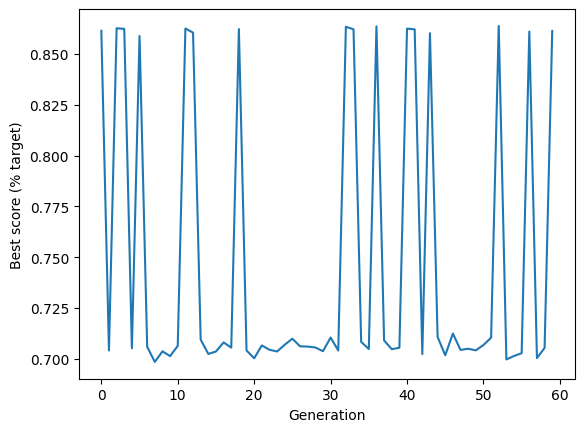

In [98]:
import matplotlib.pyplot as plt
depth = 10
num_individual = 64  # Must mod 8 = 0
maximum_generation = 60
best_score_progress = []  # Tracks progress
num_qubits = 3
threshold = 0.2

population = create_population(
    num_individual, num_qubits, depth, fitness)
best_candidate = population[0]
for generation in range(maximum_generation):
    print("Iter: ", generation)
    population = sorted(population, key=lambda obj: obj.fitness)[
        :int(num_individual/2)]
    scores = []
    new_population = []
    for i in range(0, int(num_individual/2), 2):
        parent_1 = population[i]
        parent_2 = population[i+1]
        child_1, child_2 = parent_1.crossover(parent_2)
        child_1.compile()
        child_2.compile()
        new_population.append(child_1)
        scores.append(child_1.fitness)
        new_population.append(child_2)
        scores.append(child_2.fitness)
    for score in scores:
        print(f"{score} ")

    population = new_population
    prob_mutate = 0.01
    for individual in population:
        if random.random() < prob_mutate:
            individual.mutate(qtm.evolution.mutate)

    best_score = np.min(scores)
    best_index = np.argmin(scores)
    if best_candidate.fitness > population[best_index].fitness:
        best_candidate = population[best_index]
    best_score_progress.append(best_score)
    if best_score < threshold:
        break
print(best_candidate.qc)
# GA has completed required generation
print('End best score, percent target: %.1f' % best_score)

# Plot progress
%matplotlib inline
plt.plot(best_score_progress)
plt.xlabel('Generation')
plt.ylabel('Best score (% target)')
plt.show()


In [99]:
qc = best_candidate.qc
compiler = qtm.qcompilation.QuantumCompilation(
    u=qc,
    # vdagger = qtm.state.create_w_state(qc.num_qubits).inverse(),
    vdagger=vdagger,
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler.fit(num_steps=10, verbose=1)


Step: 100%|██████████| 10/10 [00:00<00:00, 34.00it/s]


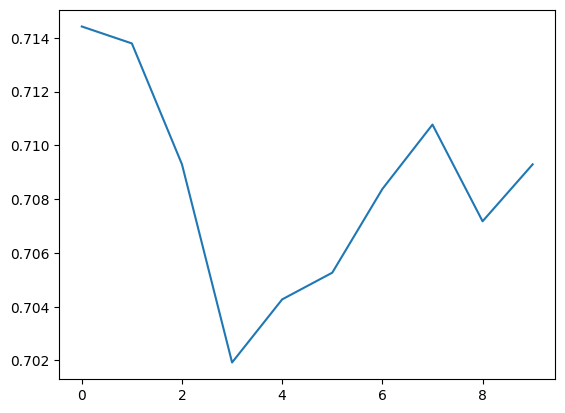

In [100]:
plt.plot(compiler.loss_values)


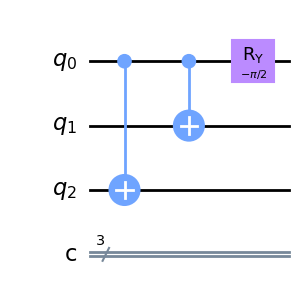

In [101]:
vdagger.draw('mpl')


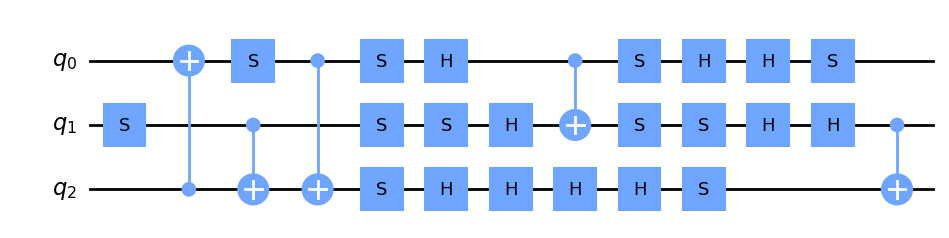

In [102]:
qc.draw('mpl')


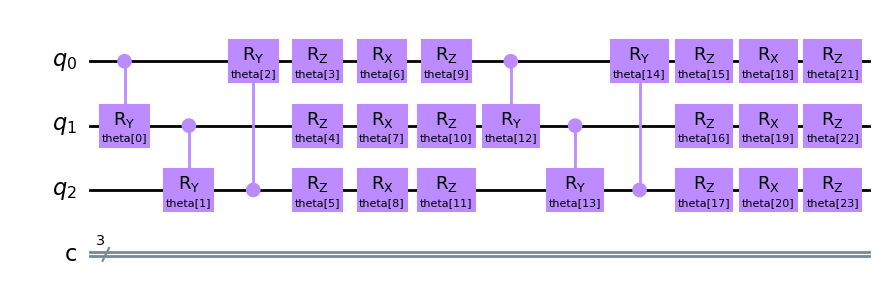

In [85]:
qtm.ansatz.create_Wchain_layered_ansatz(3, 2).draw('mpl')


In [64]:
compiler2 = qtm.qcompilation.QuantumCompilation(
    # u = random_circuit.random_circuit(3, 10),
    # vdagger = qtm.state.create_w_state(qc.num_qubits).inverse(),
    u=qtm.ansatz.create_Wchain_layered_ansatz(3, 1),
    vdagger=qc_haar,
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler2.fit(num_steps=100, verbose=1)


Step: 100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


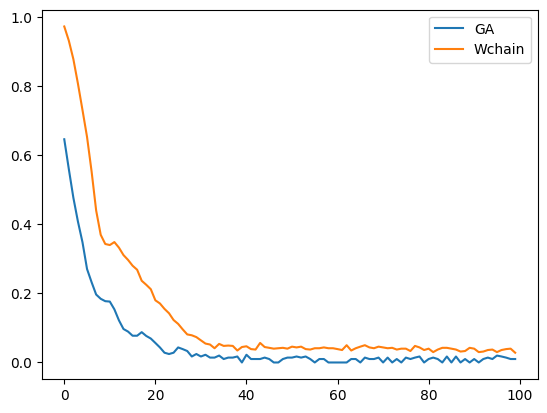

In [88]:
plt.plot(compiler.loss_values, label='GA')
plt.plot(compiler2.loss_values, label='Wchain')
plt.legend()
